In [1]:
from model import *
import mesa
import pandas as pd
import seaborn as sns
import time as time
import tqdm as tqdm

In [2]:
# Run model
begintime = time.time()

model = HousingMarket()
model.run_model(100)
data = model.datacollector.get_agent_vars_dataframe()

print(time.time() - begintime)

Step: 0
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.5949640287769784
0.620863309352518
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.39509306260575294
0.3

0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.39784172661870504
0.4273381294964029
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.5076142131979696
0.

0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7888888888888889
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8059574468085106
0.8314893617021276
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902571042
0.4871447902

0.6974358974358974
0.7307692307692307
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.39509306260575294
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.9191489361702128
0.919148

0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.3675213675213675
0.4213675213675213
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7888888888888889
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727580373
0.8240270727

0.6623931623931624
0.6623931623931624
0.6623931623931624
0.6623931623931624
0.6623931623931624
0.6623931623931624
0.6623931623931624
0.6974358974358974
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6531302876480543
0.6818950930626059
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0.49872340425531914
0

0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.39509306260575294
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5651438240270729
0.5947546531302877
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7360406091370559
0.7

0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.160431654676259
0.1920863309352518
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.21650879566982412
0.24424898511502033
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.7604871447902569
0.76048

0.4607577807848444
0.4607577807848444
0.4607577807848444
0.4607577807848444
0.4607577807848444
0.4607577807848444
0.4871447902571042
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.6190798376184032
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806
0.36548223350253806


0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.848443843031123
0.8626522327469551
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.47969543147208127
0.5076142131979696
0.3558863328822734
0.3558863328822734
0.355886

0.47350427350427343
0.47350427350427343
0.47350427350427343
0.47350427350427343
0.47350427350427343
0.47350427350427343
0.47350427350427343
0.47350427350427343
0.5256410256410255
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9065155807365439
0.9178470254957507
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.9450084602368867
0.94

0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9384303112313935
0.9445196211096073
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468085106383
0.854468

0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5302127659574468
0.5582978723404255
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424898509
0.8755074424

0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.16373477672530448
0.1894451962110961
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7615384615384615
0.7888888888888889
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072
0.5683453237410072


0.578125
0.578125
0.578125
0.578125
0.578125
0.578125
0.640625
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7395128552097427
0.7604871447902569
0.3852691218130312
0.3852691218130312
0.3852691218130312
0.3852691218130312
0.3852691218130312
0.3852691218130312
0.3852691218130312
0.3852691218130312
0.4475920679886686
0.42385786802030456
0.423

0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.5926928281461434
0.6190798376184032
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.9205128205128205
0.929059829059829
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.78888888888

0.7997293640054126
0.7997293640054126
0.7997293640054126
0.7997293640054126
0.7997293640054126
0.7997293640054126
0.7997293640054126
0.7997293640054126
0.8173207036535858
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7171853856562922
0.7395128552097427
0.5846808510638297
0.5846808510638297
0.5846808510638297
0.5846808510638297
0.5846808510638297
0.5846808510

0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.408660351826793
0.4343707713125846
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6230769230769231
0.6623931623931624
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.9598290598290596
0.959829

0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9906382978723404
0.9914893617021276
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8358974358974359
0.8547008547008548
0.9302127659574468
0.9302127659574468
0.9302127659574468
0.9302127659574468
0.9302127659574468
0.9302127659574468
0.9302127659574468
0.9302127659574468
0.9302127659574468
0.9302127659

0.8991452991452992
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.27266576454668473
0.30108254397834916
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.7888888888888889
0.8136752136752137
0.87489361

0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8722504230118444
0.8849407783417936
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036535858
0.8173207036

0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.620863309352518
0.6460431654676259
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5410071942446043
0.5683453237410072
0.5363790186125212
0.5363790186125212
0.5363790186125

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [35]:
age25 = []
age35 = []
age45 = []
age55 = []
age65 = []
age75 = []
age76 = []

for k in range(len(data["Income"][1])):
    
    if data['Age'].iloc[k] < 25:
        age25.append(data['Income'].iloc[k])
    
    if data['Age'].iloc[k] > 25 and data['Age'].iloc[k] < 35:
        age35.append(data['Income'].iloc[k])
        
    if data['Age'].iloc[k] > 35 and data['Age'].iloc[k] < 45:
        age45.append(data['Income'].iloc[k])
    
    if data['Age'].iloc[k] > 45 and data['Age'].iloc[k] < 55:
        age55.append(data['Income'].iloc[k])
        
    if data['Age'].iloc[k] > 55 and data['Age'].iloc[k] < 65:
        age65.append(data['Income'].iloc[k])
        
    if data['Age'].iloc[k] > 65 and data['Age'].iloc[k] < 75:
        age75.append(data['Income'].iloc[k])

    if data['Age'].iloc[k] > 75:
        age76.append(data['Income'].iloc[k])

<AxesSubplot:ylabel='Count'>

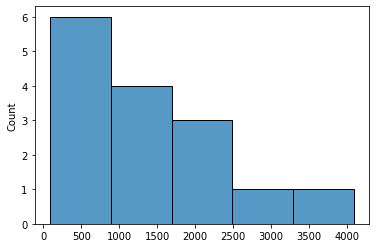

In [36]:
sns.histplot(age25)

<AxesSubplot:ylabel='Count'>

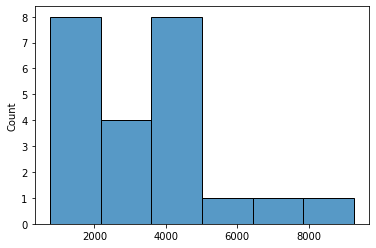

In [37]:
sns.histplot(age35)

<AxesSubplot:ylabel='Count'>

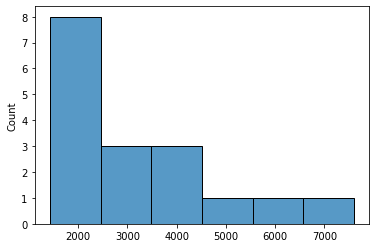

In [38]:
sns.histplot(age45)

<AxesSubplot:ylabel='Count'>

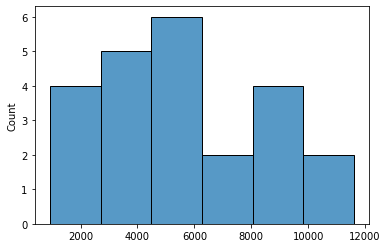

In [39]:
sns.histplot(age55)

<AxesSubplot:ylabel='Count'>

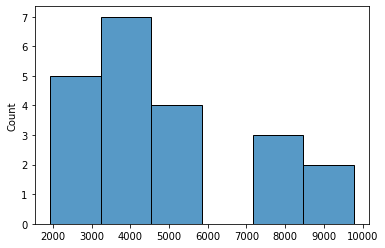

In [40]:
sns.histplot(age65)

<AxesSubplot:ylabel='Count'>

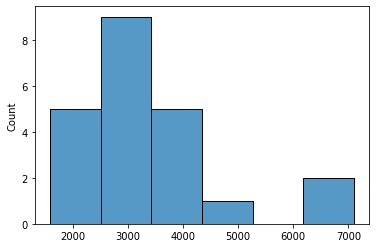

In [41]:
sns.histplot(age75)

<AxesSubplot:ylabel='Count'>

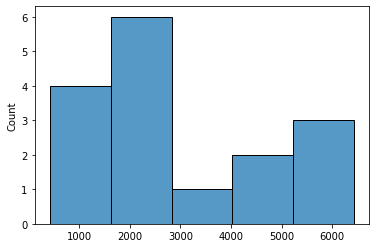

In [42]:
sns.histplot(age76)